In [ ]:
%%capture
import os
# Descargamos el dataset
if not os.path.isfile('./partes1t200.zip'):
  !gdown --id 1JHX2aU0hVjRhJP36vanSKheSu5nbu7FT
  !gdown --id 1cWobVXfRMo01Y3zuOFxoVxwiiE6l3ONC
  !gdown --id 1QWg9CXfiPlTdcXi_9SBjdeTcZt-QxTCB
  !gdown --id 1kR5m8Kfq6yALlYc8PIPLz8ktIsFkFT4Q

if not os.path.isdir('./metadata'):
  !mkdir metadata
  !unzip partes1t200.zip -d ./metadata
  !unzip partes201t350.zip -d ./metadata
  !unzip partes351t500.zip -d ./metadata
  !unzip partes501t631.zip -d ./metadata

In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from skimage import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.transform import rescale, resize, downscale_local_mean
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
import random
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input,MaxPooling2D, Dropout, Embedding, SimpleRNN, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import f1_score


In [ ]:

# Generador de datos
class DataGenerator(Sequence):

  # imgIDs: Lista de las ID de las imagenes a utilizar en este generator.
  # labels: Diccionario de los labels para cada ID (sin one hot encoding)
  # batch_size: Tamaño de cada batch que se genera por llamado.
  # dim: Dimensiones de las imagenes.
  # n_channels: Numero de canales de la imagen.
  # n_classes: Numero de labels distintos.
  # shuffle: Si revolver los datos o no.
  def __init__(self, imgIDs, text, labels, vectorizer, batch_size=32, dim=(224, 224), n_channels=3, n_classes=3, shuffle=True):
    self.imgIDs = imgIDs
    self.text = text
    self.vectorizer = vectorizer
    self.labels = labels
    self.batch_size = batch_size
    self.dim = dim
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.X_img = []
    self.X_text = []
    self.y_pred = []
    self.on_epoch_end()

  # Retorna el numero de batches del generator.
  def __len__(self):
    return int(np.floor(len(self.imgIDs) / self.batch_size))

  # Retorna un batch.
  def __getitem__(self, index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    list_IDs_temp = [self.imgIDs[k] for k in indexes]
    X, y = self.__data_generation(list_IDs_temp)
    return X, y

  # Cuando se termina un epoch, se escogen los siguientes ID.
  def on_epoch_end(self):
    self.indexes = np.arange(len(self.imgIDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  # Se cargan los datos a medida que se necesitan.
  def __data_generation(self, list_IDs_temp):
    X_img = np.empty((self.batch_size, *self.dim, self.n_channels))
    X_txt = []
    y = np.empty((self.batch_size), dtype=int)
    
    for i, ID in enumerate(list_IDs_temp):
      rgb = io.imread("./metadata/balanced_dataset_medium/data/" + ID + ".jpg")
      resized_image = resize(rgb, self.dim)
      rescaled_image = 255 * resized_image
      final_image = rescaled_image.astype(np.uint8)
      X_txt.append(self.text[ID])
      X_img[i,] = final_image
      y[i] = self.labels[ID]
    X_txt = self.vectorizer(np.array(X_txt)).numpy()
    X_img = X_img.astype(np.uint8)
    return [X_txt, X_img], to_categorical(y, num_classes=self.n_classes)

(180, 320, 3)

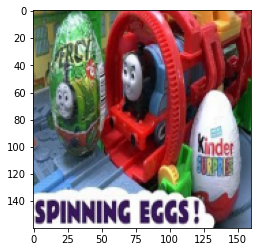

In [ ]:
rgb = io.imread("./metadata/balanced_dataset_medium/data/idXBOjJE8oFIY_video.jpg")
resized_image = resize(rgb, (160, 160))
# Convert the image to a 0-255 scale.
rescaled_image = 255 * resized_image
# Convert to integer data type pixels.
final_image = rescaled_image.astype(np.uint8)
# show resized image
plt.imshow(final_image)
rgb.shape

In [ ]:
def changeLabels(df):
  for i, row in enumerate(df.values):
    if row[4] < 100000:
      df.loc[i,'label'] = 0
    elif row[4] < 1000000:
      df.loc[i,'label'] = 1
    else:
      df.loc[i,'label'] = 2
  return df

In [ ]:
# Observamos los datos del CSV.
data_info_1 =  pd.read_csv("/content/metadata/balanced_dataset_medium/data_info.csv")
data_info_1 = changeLabels(data_info_1)
data_info_2 =  pd.read_csv("/content/metadata/balanced_dataset_medium/data_info2.csv")
data_info_2 = changeLabels(data_info_2)
data_info_3 =  pd.read_csv("/content/metadata/balanced_dataset_medium/data_info3.csv")
data_info_3 = changeLabels(data_info_3)
data_info_4 =  pd.read_csv("/content/metadata/balanced_dataset_medium/data_info4.csv")
data_info_4 = changeLabels(data_info_4)

dataInfo = pd.concat([data_info_1,data_info_2,data_info_3,data_info_4])
dataInfo

,Unnamed: 0,ID,part,label,views,comments,likes,dislikes,topicID,title,description,channelName,tags
0,0,idWu9-2LhgiAg_video,part558,0,1365,0.0,1.0,0.0,/m/07yv9 /m/019_rr /m/019_rr /m/07yv9 /m/03glg,raptor 50,1er vol en ecolage avec fisheye,eric vella,helico r/c thermique
1,1,idwtjIGgXvB_o_video,part558,0,22509,29.0,81.0,4.0,/m/07yv9 /m/0410tth /m/019_rr /m/019_rr /m/07y...,best jdm cars,song:universe artist:xilent (ft. shaz sparks) ...,Takashi White,nissan cars nismo drifting speed 240sx skyline...
2,2,idwTryXOMkDIA_video,part558,0,1710,2.0,8.0,0.0,/m/07bxq /m/019_rr /m/019_rr /m/07yv9 /m/07bxq...,ultralight flying over lake powell and monumen...,aerial photos of lake powell and monument valley,Pete Sigrist,ultralights lake monuments utah scenic page az
3,3,idwTemKnL8X30_video,part558,1,108096,42.0,77.0,9.0,/m/07yv9 /m/019_rr /m/019_rr /m/07yv9,near mid air collision,http://www.chasingclouds.net a plane towing a...,gregc9,near mid air collision parachute cirrus plane ...
4,4,idWToqs2xDW4o_video,part558,0,4799,1.0,8.0,2.0,/m/07yv9 /m/019_rr /m/019_rr /m/07yv9,red occ schwinn stingray chopper motorized bic...,pedalchoppers red occ schwinn stingray chopper...,pedalchopper1,occ schwinn stingray chopper bicycle pedalchop...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15491,15491,idWNyNjqb-9sU_video,part555,2,1186308,163.0,1670.0,249.0,/m/07yv9 /m/0410tth /m/019_rr /m/019_rr /m/07y...,adu cepat lamborghini vs jet tempur f16,,sekilasinfo,adu cepat lamborghini vs jet tempur f16
15492,15492,idwPbj19mJ02Q_video,part555,2,1759960,1652.0,10121.0,524.0,/m/07yv9 /m/0410tth /m/019_rr /m/019_rr /m/07y...,fastest car in the world — lamborghini gallard...,instagram владельца (owner's instagram): http:...,DragtimesInfo,unlim 500+ destination greece lamborghini gall...
15493,15493,idWp3oni7VDG0_video,part555,2,1093093,374.0,285.0,287.0,/m/07yv9,【事故】無謀な車線変更でトラックが追突,2011/08/24 08:12 福岡県3号線下り 箱崎ふ頭中央入口でおこった追突事故です。...,Tuneit,事故 caraccident 福岡 無謀運転 車線変更禁止 10t
15494,15494,idWnwx9y5G0rI_video,part555,2,1236458,52.0,654.0,222.0,/m/07yv9 /m/019_rr /m/019_rr /m/07yv9,elephants in sri lanka by shehan.d.iddamalgoda.,elephants live around sri lankan national park...,Shehan Iddamalgoda,elephant (2003 film) elephant (album) sri lank...


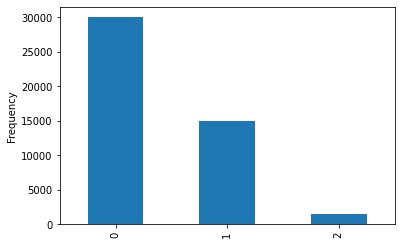

In [ ]:
value_counts2 = dataInfo['label'].value_counts()
value_counts2

dataInfo.groupby('label').size().plot.hist()
dataInfo['label'].value_counts().plot.bar()

In [ ]:
dataInfo = dataInfo.dropna()

df2 = dataInfo[(dataInfo['label'] == 0)]
df3 = dataInfo[(dataInfo['label'] == 1)]
df4 = dataInfo[(dataInfo['label'] == 2)]

vals = len(df4)

df6 = df2.iloc[:vals]
df7 = df3.iloc[:vals]
df8 = df4.iloc[:vals]

bigdata = pd.concat([df6, df7, df8], ignore_index=True, sort=False)
bigdata

,Unnamed: 0,ID,part,label,views,comments,likes,dislikes,topicID,title,description,channelName,tags
0,0,idWu9-2LhgiAg_video,part558,0,1365,0.0,1.0,0.0,/m/07yv9 /m/019_rr /m/019_rr /m/07yv9 /m/03glg,raptor 50,1er vol en ecolage avec fisheye,eric vella,helico r/c thermique
1,1,idwtjIGgXvB_o_video,part558,0,22509,29.0,81.0,4.0,/m/07yv9 /m/0410tth /m/019_rr /m/019_rr /m/07y...,best jdm cars,song:universe artist:xilent (ft. shaz sparks) ...,Takashi White,nissan cars nismo drifting speed 240sx skyline...
2,2,idwTryXOMkDIA_video,part558,0,1710,2.0,8.0,0.0,/m/07bxq /m/019_rr /m/019_rr /m/07yv9 /m/07bxq...,ultralight flying over lake powell and monumen...,aerial photos of lake powell and monument valley,Pete Sigrist,ultralights lake monuments utah scenic page az
3,4,idWToqs2xDW4o_video,part558,0,4799,1.0,8.0,2.0,/m/07yv9 /m/019_rr /m/019_rr /m/07yv9,red occ schwinn stingray chopper motorized bic...,pedalchoppers red occ schwinn stingray chopper...,pedalchopper1,occ schwinn stingray chopper bicycle pedalchop...
4,5,idwTu8a5YEZt8_video,part558,0,24818,0.0,39.0,5.0,/m/07yv9,"car tuning, autos modificados, sonido sobre ru...","car tuning, autos modificados, sonido sobre ru...",TOTTY Tips,carrera autos crash ride chase cars car tuning...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4021,15491,idWNyNjqb-9sU_video,part555,2,1186308,163.0,1670.0,249.0,/m/07yv9 /m/0410tth /m/019_rr /m/019_rr /m/07y...,adu cepat lamborghini vs jet tempur f16,,sekilasinfo,adu cepat lamborghini vs jet tempur f16
4022,15492,idwPbj19mJ02Q_video,part555,2,1759960,1652.0,10121.0,524.0,/m/07yv9 /m/0410tth /m/019_rr /m/019_rr /m/07y...,fastest car in the world — lamborghini gallard...,instagram владельца (owner's instagram): http:...,DragtimesInfo,unlim 500+ destination greece lamborghini gall...
4023,15493,idWp3oni7VDG0_video,part555,2,1093093,374.0,285.0,287.0,/m/07yv9,【事故】無謀な車線変更でトラックが追突,2011/08/24 08:12 福岡県3号線下り 箱崎ふ頭中央入口でおこった追突事故です。...,Tuneit,事故 caraccident 福岡 無謀運転 車線変更禁止 10t
4024,15494,idWnwx9y5G0rI_video,part555,2,1236458,52.0,654.0,222.0,/m/07yv9 /m/019_rr /m/019_rr /m/07yv9,elephants in sri lanka by shehan.d.iddamalgoda.,elephants live around sri lankan national park...,Shehan Iddamalgoda,elephant (2003 film) elephant (album) sri lank...


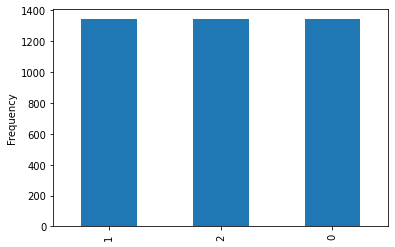

In [ ]:
value_counts2 = bigdata['label'].value_counts()
value_counts2

bigdata.groupby('label').size().plot.hist()
bigdata['label'].value_counts().plot.bar()

In [ ]:
# Tamaño de los grupos, donde se indica con proporciones.
# El resto se le asigna al grupo de test.
trainSize = 0.6
valSize = 0.2

# Generamos el diccionario de los labels, y cargamos todos los IDs en una lista.
labels = {}
data = []
text = {}
vecText = []

for i, row in bigdata.iterrows():
  vecText.append(row["title"] + " " + row["description"] + " " + row["channelName"])
  text[row["ID"]] = row["title"] + " " + row["description"] + " " + row["channelName"]
  data.append(row["ID"])
  labels[row["ID"]] = row["label"]

# Revolvemos la lista de ID.
random.Random().shuffle(data)

# Generamos las listas de IDs para cada grupo.
trainData = data[:int(len(data)*trainSize)]
valData = data[int(len(data)*trainSize) : int(len(data)*trainSize) + int(len(data)*valSize)]
testData = data[int(len(data)*trainSize) + int(len(data)*valSize):]

# Creamos el diccionario de listas de ID para cada grupo.
partition = {}
partition["train"] = trainData
partition["validation"] = valData
partition["test"] = testData

In [ ]:
maxLen = max(len(a.split()) for a in vecText)
print(maxLen)

824


In [ ]:
#inicialización del metodo que vectoriza el texto, se le ingresa el vocabulario a codificar
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=maxLen)
text_ds = tf.data.Dataset.from_tensor_slices(np.array(vecText)).batch(128)
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))



---


**Data Generators**

---



In [ ]:
# Creamos los generadores.
trainGenerator = DataGenerator(partition["train"], text, labels, vectorizer)
valGenerator = DataGenerator(partition["validation"], text, labels, vectorizer)
testGenerator = DataGenerator(partition["test"], text, labels, vectorizer)

In [ ]:
PATH = './metadata/balanced_dataset_medium/'
train_dir = os.path.join(PATH, 'data')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

17612800/17605208 [==============================] - 0s 0us/step


In [ ]:
iterable = iter(trainGenerator)
for i in range(3):
  X, labels = next(iterable)
#feature_batch = base_model(image_batch)
#print(feature_batch.shape)

[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


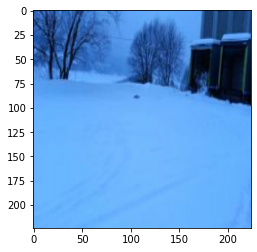

In [ ]:
#len(X[0])
plt.imshow(X[1][2])
print(labels)

In [ ]:
base_model.trainable = False

In [ ]:
# if not os.path.isfile('./glove.42B.300d.txt'):
#   !gdown --id 1gwdbSac4nlb66wHc-LpOkvlSNBTN5aoX

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Lee matrices del embedding
embeddings_index = {}
f = open('./drive/MyDrive/Copy of glove.42B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1917494 word vectors.


In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            input_length=maxLen,
                            trainable=False, name='embed_1')

In [ ]:
prediction_layer = tf.keras.layers.Dense(32, activation='sigmoid')
pooling_layer = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
#modelo de imagenes
IMGinput = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(IMGinput)
x = base_model(x, training=False)
x = pooling_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.layers.Flatten()(x)
#x = tf.keras.layers.Dense(1280, activation='relu')(x)
#x = tf.keras.layers.Dropout(0.4)(x)
IMGoutput = prediction_layer(x)
model_img = tf.keras.Model(IMGinput, IMGoutput)

In [ ]:
embedding_dim = 128

In [ ]:
!gdown --id 1O1G-_tUbv3vZJpBUANCmr4CcOxDoZc47

Downloading...
From: https://drive.google.com/uc?id=1O1G-_tUbv3vZJpBUANCmr4CcOxDoZc47
To: /content/model_text.h5
25.1MB [00:01, 16.6MB/s]


In [ ]:
#modelo de texto
model = Sequential([
  embedding_layer,
  tf.keras.layers.GRU(embedding_dim, return_sequences=True,name='gru_1'),
  tf.keras.layers.GRU(embedding_dim,name='gru_2'),
  Dense(embedding_dim/4, activation='relu', name='dense_1'),
  tf.keras.layers.Dropout(0.2),
  Dense(3, activation='sigmoid')
])

model.load_weights('model_text.h5', by_name=True)

In [ ]:
model_img.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
MobilenetV3large (Functional (None, 7, 7, 1280)        4226432   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                40992     
Total params: 4,267,424
Trainable params: 40,992
Non-trainable params: 4,226,432
_________________________________________________________________


In [ ]:
model_text.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 824, 300)          6000300   
_________________________________________________________________
gru_2 (GRU)                  (None, 824, 128)          165120    
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               99072     
_________________________________________________________________
dense_8 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                1056      
Total params: 6,269,676
Trainable params: 269,376
Non-trainable params: 6,000,300
______________________________________

In [ ]:
# input_text = tf.keras.Input(shape=(300,))
# x2 = embedding_layer(input_text)
# x2 = tf.keras.layers.GRU(embedding_dim, return_sequences=True)(input_text)
# x2 = tf.keras.layers.GRU(embedding_dim)(x2)

x3 = tf.keras.layers.concatenate([model_text.output, model_img.output])
x3 = Dense(32, activation='sigmoid')(x3)
#x3 = tf.keras.layers.Dropout(0.2)(x3)

output = Dense(3, activation='softmax')(x3)
model = tf.keras.Model([model_text.input, IMGinput], output)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.001)

In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_input (InputLayer)    [(None, 824)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 824, 300)     6000300     embedding_input[0][0]            
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, 824, 128)     165120      embedding[1][0]                  
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
____________________________________________________________________________________________

In [ ]:
history = model.fit(trainGenerator, validation_data=valGenerator, epochs = 100, callbacks=[stopping, reduce_lr])

Epoch 1/100
75/75 [==============================] - 59s 718ms/step - loss: 1.0881 - accuracy: 0.3983 - val_loss: 1.0664 - val_accuracy: 0.4363
Epoch 2/100
75/75 [==============================] - 51s 684ms/step - loss: 1.0455 - accuracy: 0.4650 - val_loss: 1.0456 - val_accuracy: 0.4700
Epoch 3/100
75/75 [==============================] - 51s 677ms/step - loss: 1.0064 - accuracy: 0.5221 - val_loss: 1.0409 - val_accuracy: 0.4613
Epoch 4/100
75/75 [==============================] - 51s 684ms/step - loss: 0.9819 - accuracy: 0.5200 - val_loss: 1.0309 - val_accuracy: 0.4825
Epoch 5/100
75/75 [==============================] - 51s 682ms/step - loss: 0.9620 - accuracy: 0.5400 - val_loss: 1.0557 - val_accuracy: 0.4500
Epoch 6/100
75/75 [==============================] - 51s 674ms/step - loss: 0.9405 - accuracy: 0.5483 - val_loss: 1.0550 - val_accuracy: 0.4663
Epoch 7/100
75/75 [==============================] - 51s 679ms/step - loss: 0.9403 - accuracy: 0.5512 - val_loss: 1.0741 - val_accuracy:

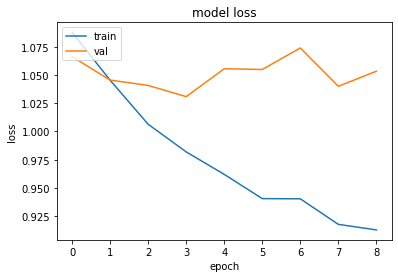

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

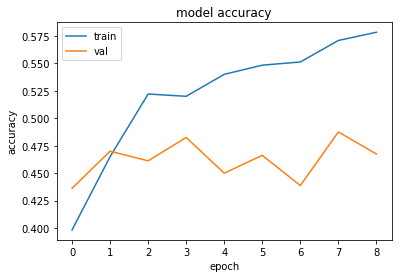

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_pred = []
y_real = []
for x,y in testGenerator:
  y_real.append(y)
  y_pred.append(model.predict(x))

In [ ]:
y_predicted = []
y_true = []

for i in range(len(y_pred)):
  for j in range(len(y_pred[i])):
    y_predicted.append(np.argmax(y_pred[i][j]))
    y_true.append(np.argmax(y_real[i][j]))

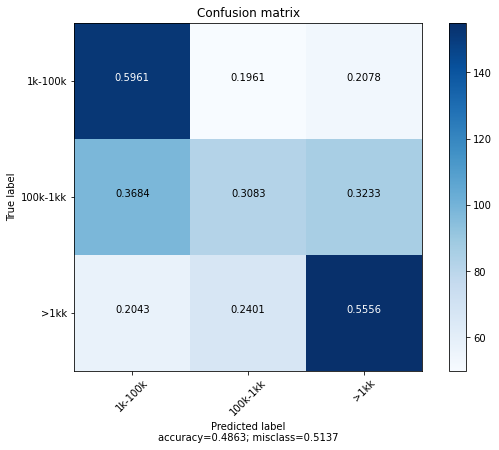

In [ ]:
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix as cf
from sklearn.metrics import classification_report


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

c_m = cf(y_true, y_predicted)
plot_confusion_matrix(c_m,["1k-100k", "100k-1kk",">1kk"])

In [ ]:
print(f1_score(y_real, y_pred, average='binary'))